# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

Use BERT.

## Inicialización

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
df_reviews.sample(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
16852,tt0226771,tvMovie,Homicide: The Movie,Homicide: The Movie,2000,\N,88,0,"Crime,Drama",7.8,1709,* Some spoilers * This movie is sometimes subt...,3,neg,0,train,2534
2273,tt0088708,movie,American Ninja,American Ninja,1985,\N,95,0,"Action,Adventure,Romance",5.5,13436,For many year I saw this movie as a real movie...,1,neg,0,test,11208
28362,tt0122459,movie,Return to Me,Return to Me,2000,\N,115,0,"Comedy,Drama,Romance",6.9,19238,"I saw this movie with my mother, and I loved i...",10,pos,1,test,1850
11633,tt0116191,movie,Emma,Emma,1996,\N,120,0,"Comedy,Drama,Romance",6.6,34947,I'm a huge Jane Austen fan and besides being a...,9,pos,1,train,10519
6936,tt0297827,movie,Checkout,Checkout,2002,\N,100,0,Comedy,5.1,56,I went in to this movie thinking it was going ...,4,neg,0,train,9231


In [7]:
df_reviews['pos'].value_counts() #No hay desequilibrio de clases

0    23715
1    23616
Name: pos, dtype: int64

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

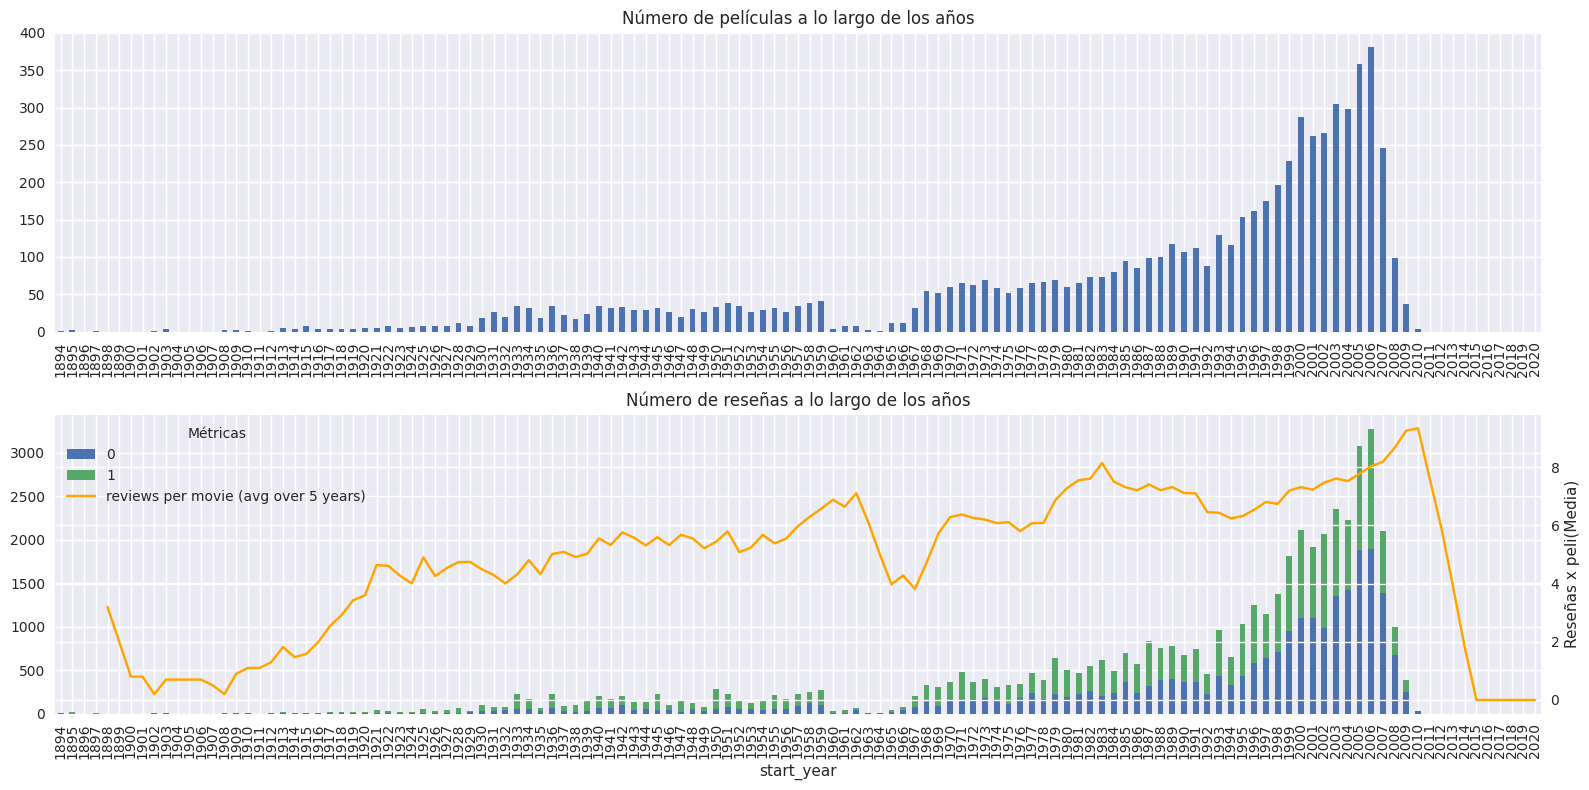

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax) 
handles1, labels1 = ax.get_legend_handles_labels() #Para abstraer leyendas de positivo y negativo

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)
handles2, labels2 = axt.get_legend_handles_labels() #Para abstraer leyndas del dft3(media)
axt.set_ylabel('Reseñas x peli(Media)')

allhandles = handles1 + handles2
all_labels = labels1 + labels2
#lines, labels = axt.get_legend_handles_labels()
ax.legend(allhandles, all_labels, loc='upper left', title='Métricas')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

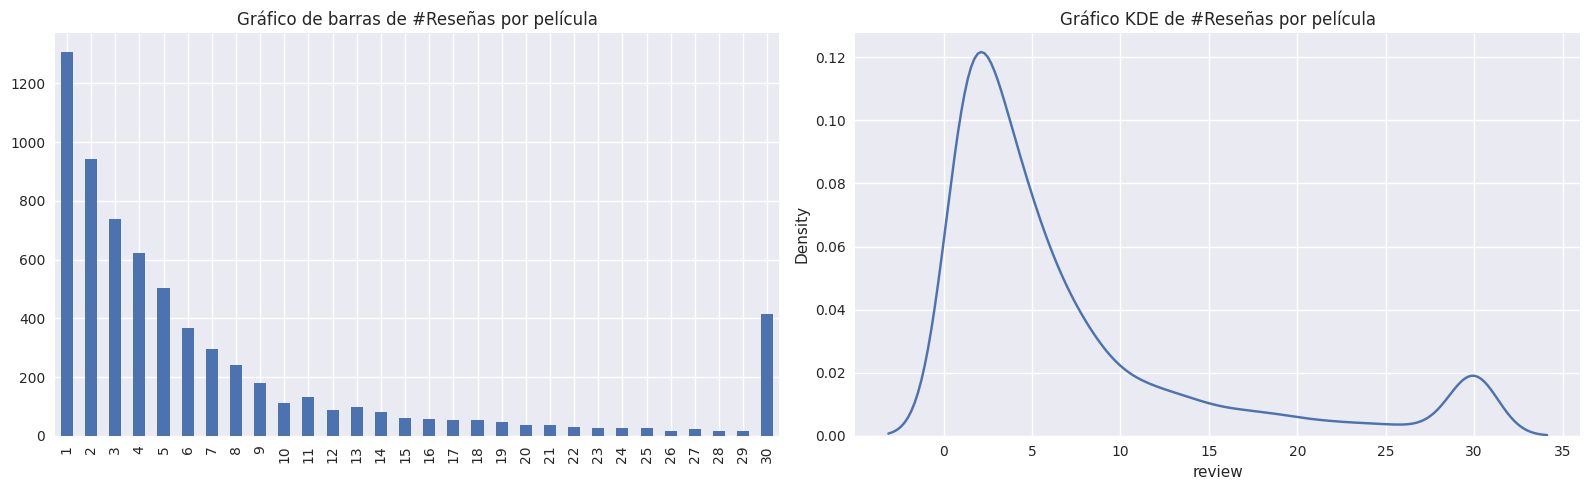

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [10]:
#La mayoria de las peliculas tienen una sola reseña, y de ahí va disminuyendo el número dereseñas
# Llegando a 30, hay un incremento considerable de pelis con este numero de reseñas.

In [11]:
df_reviews['pos'].value_counts() # No hay desequilibrio de clases

0    23715
1    23616
Name: pos, dtype: int64

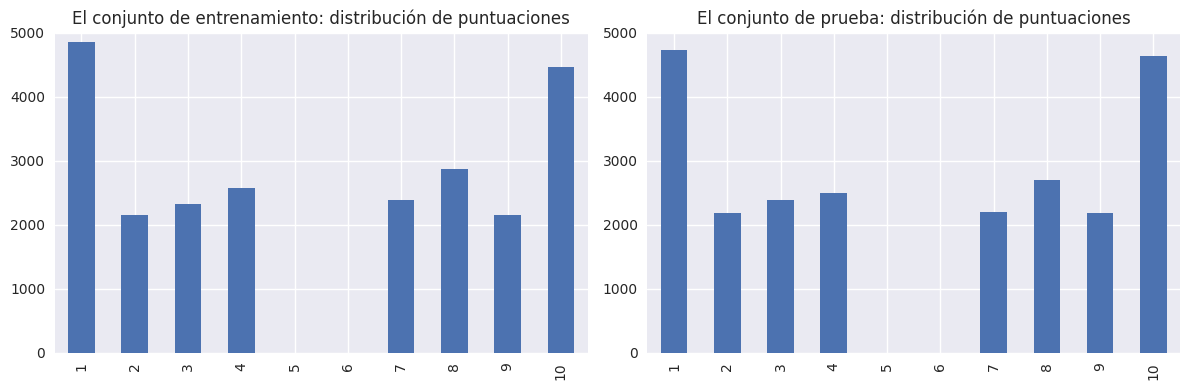

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

In [13]:
#Los ratings en ambos sets tienen una distribución similar

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


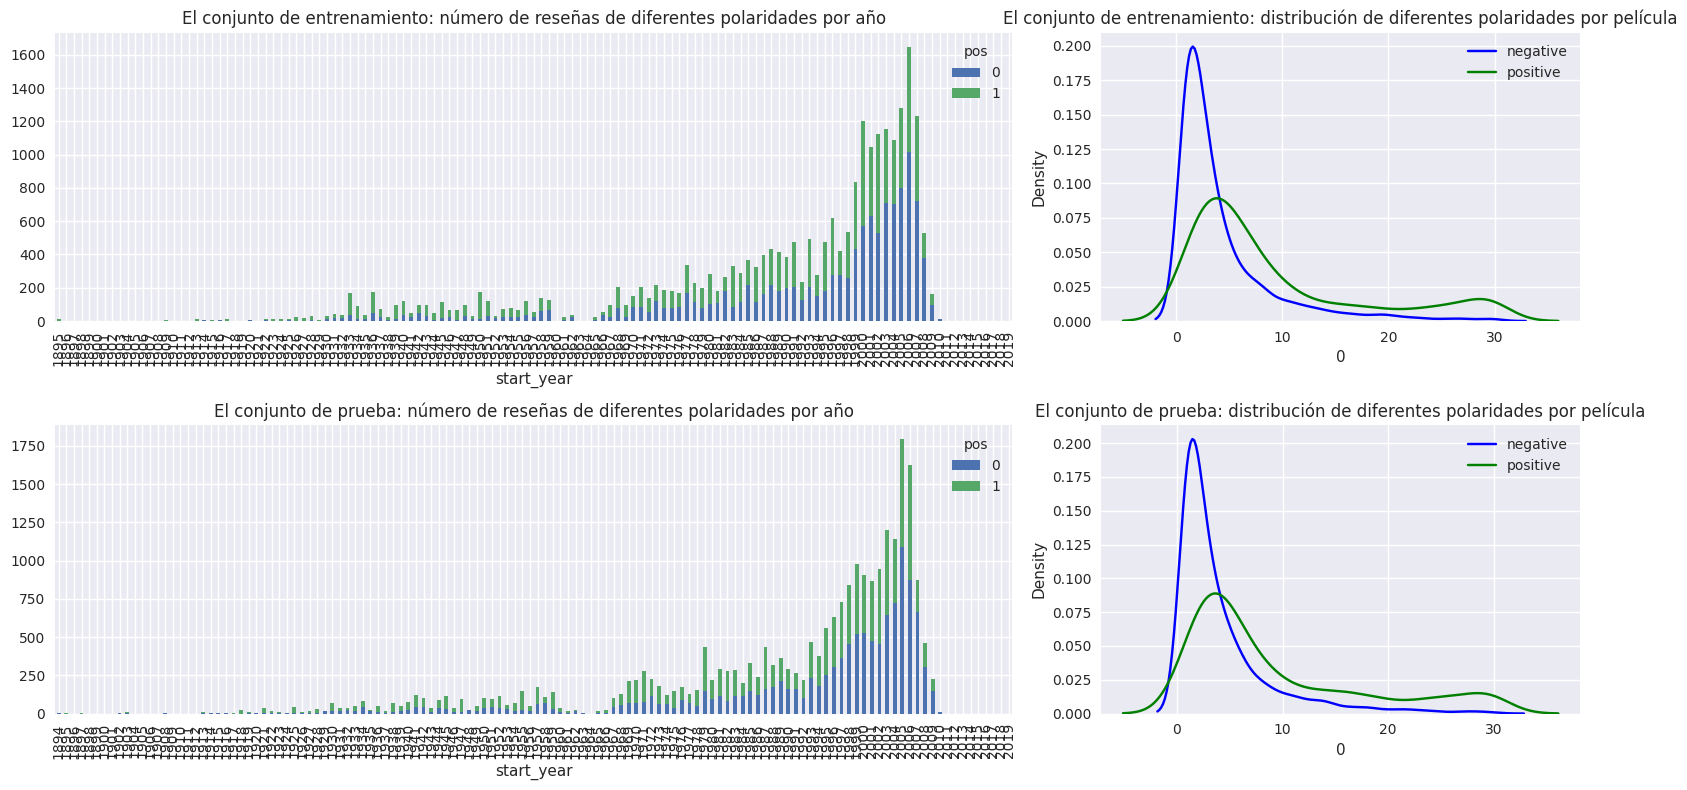

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

In [15]:
#Las distribuciones son similares por lo que no hay desequilibrio de clases

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [16]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [17]:
import spacy

nlp = spacy.load('en_core_web_sm', disable = ['parser','ner'])

def lemmatize(text):
    doc= nlp(text)
    
    lemmas = [token.lemma_.lower() for token in doc if not token.is_punct] #and not token.is_stop si queremos incluir las stop words desde este paso
    return lemmas
    
df_reviews['review_norm'] = df_reviews['review'].apply(lemmatize)


In [18]:
df_reviews['review_norm'].sample(5)

38960    [what, distinguish, some, of, the, lone, star,...
44407    [i, be, be, in, no, way, facetious, when, i, s...
41922    [do, not, let, my, constructive, criticism, st...
6194     [as, most, people, i, be, tired, of, the, by, ...
29897    [wow, most, of, the, audience, just, seem, to,...
Name: review_norm, dtype: object

In [19]:
df_reviews['review_string'] = df_reviews['review_norm'].apply(lambda x:' '.join(x))

In [20]:
df_reviews.sample(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm,review_string
31116,tt0346156,movie,Sky Captain and the World of Tomorrow,Sky Captain and the World of Tomorrow,2004,\N,106,0,"Action,Adventure,Mystery",6.0,80663,What a waste of time! I've tried to sit throug...,1,neg,0,train,11256,"[what, a, waste, of, time, i, 've, try, to, si...",what a waste of time i 've try to sit through ...
24151,tt0087799,movie,Night of the Comet,Night of the Comet,1984,\N,95,0,"Comedy,Horror,Sci-Fi",6.4,17806,That's a problem I have with movies that come ...,2,neg,0,train,6397,"[that, be, a, problem, i, have, with, movie, t...",that be a problem i have with movie that come ...
467,tt0370244,movie,9 Souls,Nain souruzu,2003,\N,120,0,"Adventure,Comedy,Crime",7.2,1594,Here is another great film critics will love. ...,3,neg,0,test,496,"[here, be, another, great, film, critic, will,...",here be another great film critic will love th...
13435,tt0049223,movie,Forbidden Planet,Forbidden Planet,1956,\N,98,0,"Action,Adventure,Sci-Fi",7.6,44037,There were a lot of 50's sci-fi movies. They w...,10,pos,1,train,7714,"[there, be, a, lot, of, 50, 's, sci, fi, movie...",there be a lot of 50 's sci fi movie they be b...
43734,tt0378879,movie,Tintin et moi,Tintin et moi,2003,\N,75,0,"Biography,Documentary",7.6,590,"Some thirty years ago, Author Numa Sadoul publ...",7,pos,1,train,12262,"[some, thirty, year, ago, author, numa, sadoul...",some thirty year ago author numa sadoul publis...


## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [21]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 19)
(23535, 19)


## Trabajar con modelos

### Modelo 1 - Constante

In [22]:
from sklearn.dummy import DummyClassifier

In [23]:
dummy_st = DummyClassifier(strategy = 'stratified')

In [24]:
dummy_st.fit(df_reviews_train, train_target)

DummyClassifier(strategy='stratified')

          train  test
Accuracy   0.50  0.50
F1         0.49  0.50
APS        0.50  0.50
ROC AUC    0.50  0.49


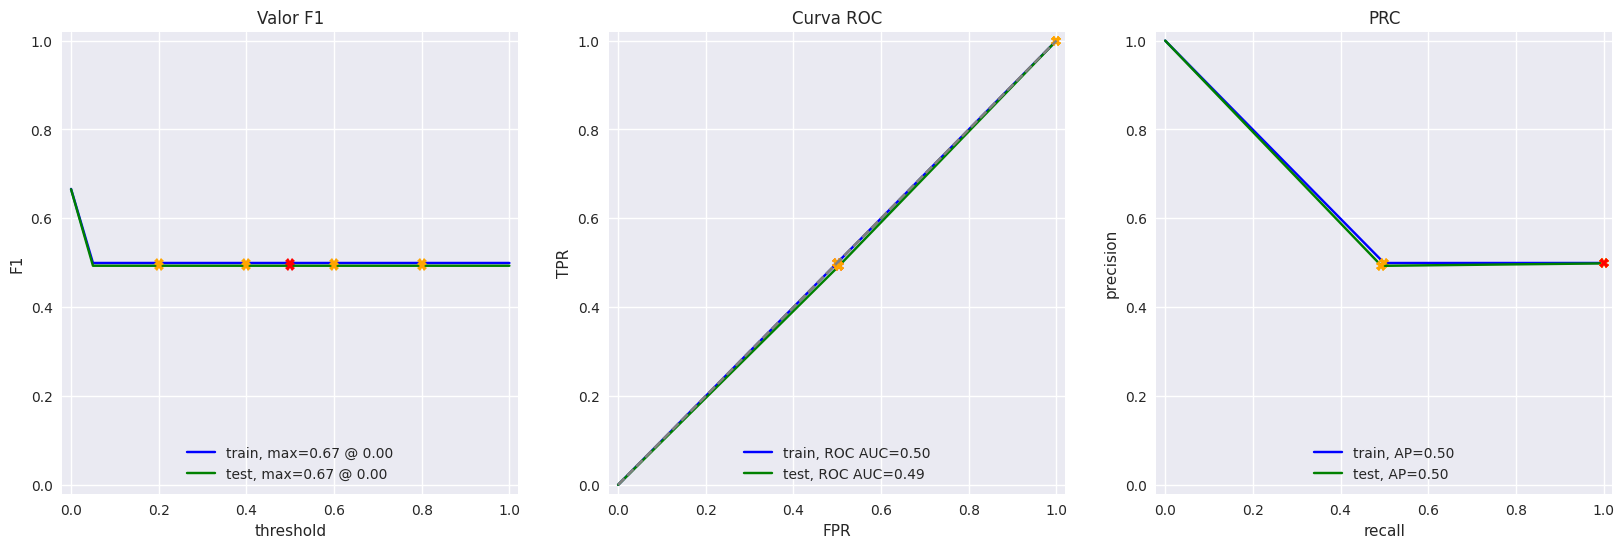

In [25]:
evaluate_model(dummy_st, df_reviews_train, train_target, df_reviews_test, test_target)

### Modelo 2 - NLTK, TF-IDF y LR

TF-IDF

In [26]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords as nltk_stopwords


In [ ]:
train_corpus = df_reviews_train['review_string'] # Se define la columna de entrenamiento
stop_words = set(nltk_stopwords.words('english')) 
count_tf_idf = TfidfVectorizer(stop_words = stop_words) #Se define el vectorizador
tf_idf = count_tf_idf.fit_transform(train_corpus) #Se transforma y se entrena

In [28]:
train_features_1 = tf_idf #Definimos el conjunto de entrenamiento para el modelo

test_corpus = df_reviews_test['review_string'] #Definimos el target
test_features_1 = count_tf_idf.transform(test_corpus) #Transformamos el conjunto de prueba

model_1 = LogisticRegression()
model_1.fit(train_features_1, train_target)

LogisticRegression()

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


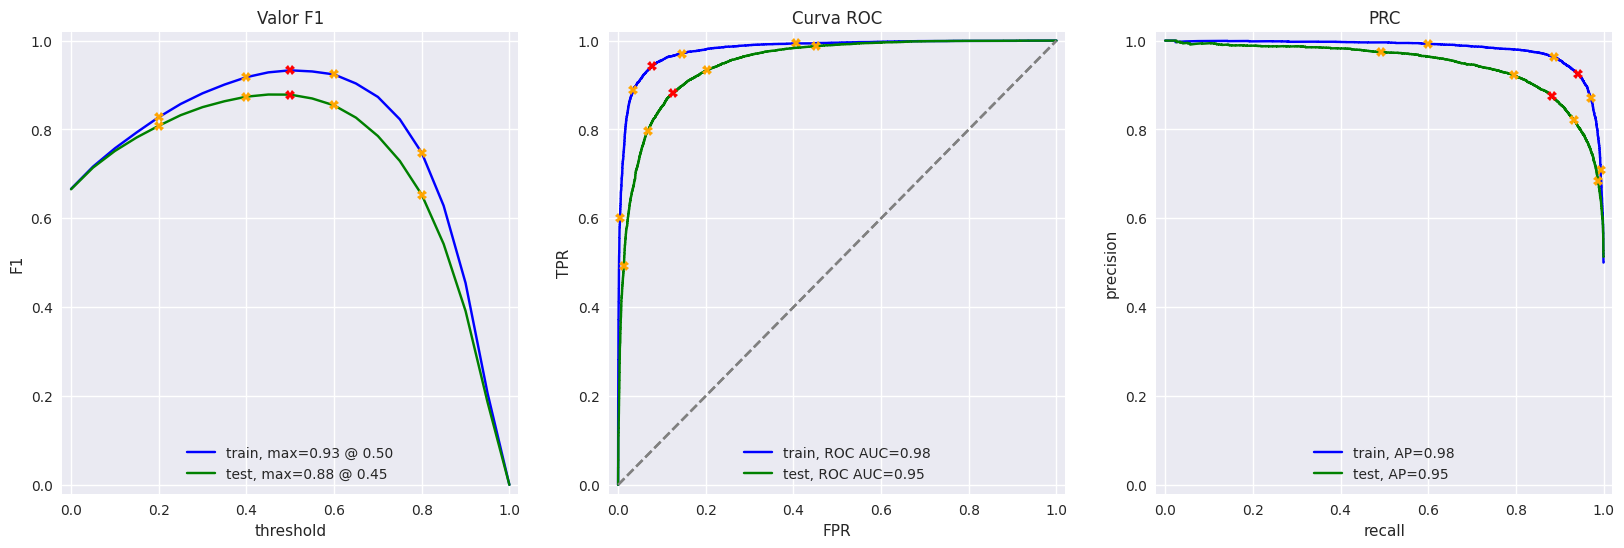

In [29]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Modelo 3 - spaCy, TF-IDF y LR

In [30]:
import spacy


nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

Este paso ya se hizo en la parte de normalización

def text_preprocessing_3(text):

    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]

    return ' '.join(tokens)

In [31]:
tf_idf_nlp = TfidfVectorizer()
tf_idf_matrix = tf_idf_nlp.fit_transform(train_corpus)

ft_names_nlp = tf_idf_nlp.get_feature_names()
ft_names_nlp[0:5]

['00', '000', '0000000000001', '00001', '00015']

In [32]:
train_features_2 = tf_idf_matrix
test_features_2 = tf_idf_nlp.transform(test_corpus)

model_2 = LogisticRegression()
model_2.fit(train_features_2, train_target)

LogisticRegression()

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


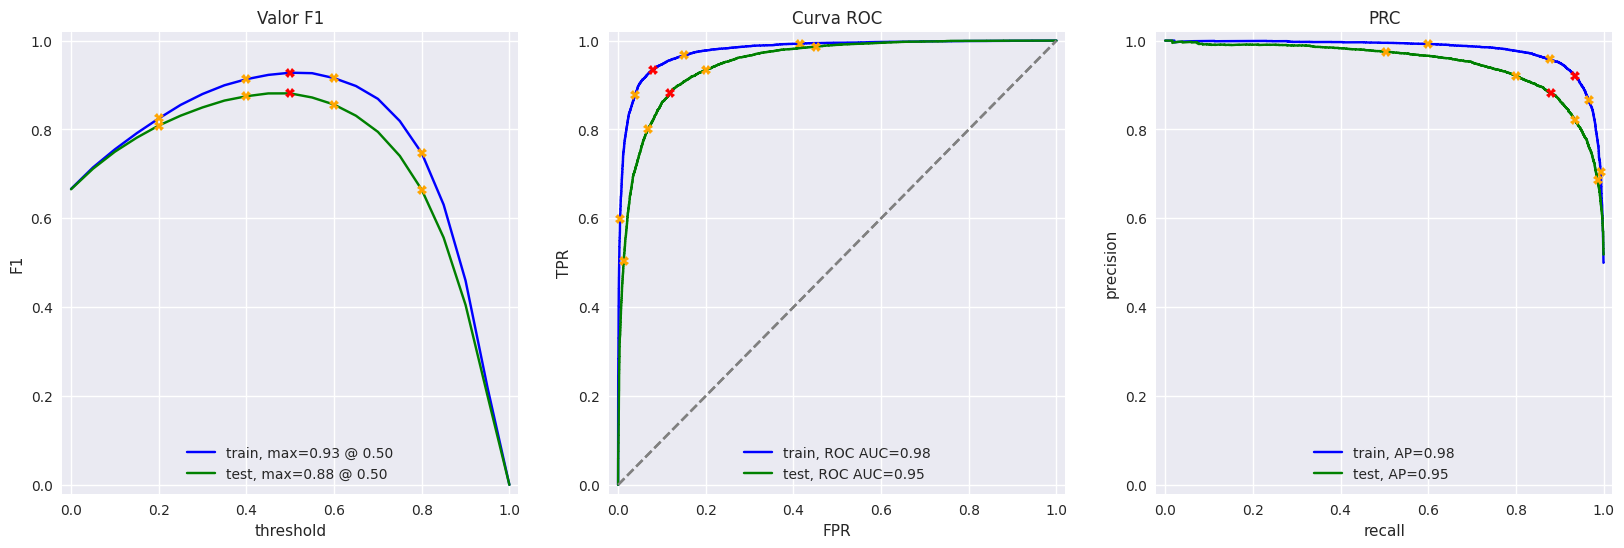

In [33]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [34]:
import lightgbm
from lightgbm import LGBMClassifier

In [35]:
gbm = LGBMClassifier(learning_rate= .03, n_estimators= 1000, num_leaves= 50, min_child_samples= 40,
                     subsample= .8, subsample_freq= 1, colsample_bytree= .9 ,random_state= 123)

In [36]:
gbm.fit(train_features_1, train_target, eval_set=[(test_features_1, test_target)], callbacks=[lightgbm.early_stopping(100, verbose=False)])

LGBMClassifier(colsample_bytree=0.9, learning_rate=0.03, min_child_samples=40,
               n_estimators=1000, num_leaves=50, random_state=123,
               subsample=0.8, subsample_freq=1)

          train  test
Accuracy   0.99  0.88
F1         0.99  0.88
APS        1.00  0.95
ROC AUC    1.00  0.95


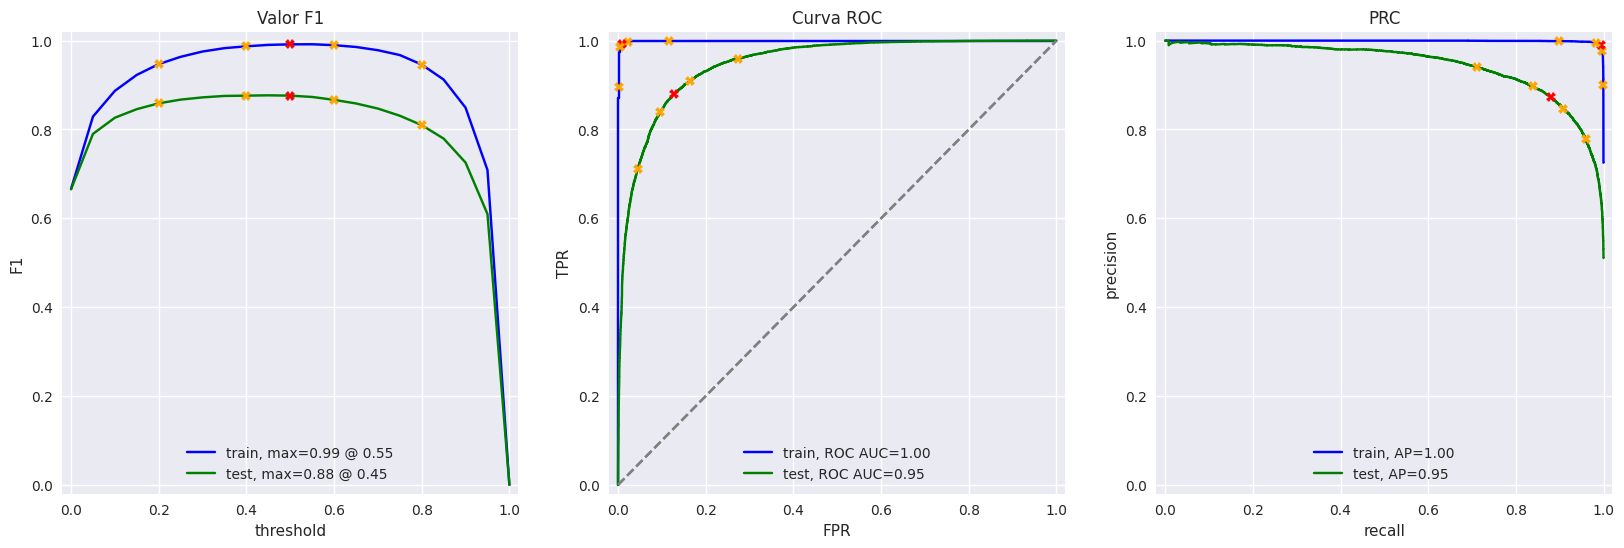

In [37]:
evaluate_model(gbm, train_features_1, train_target, test_features_1, test_target)

In [38]:
#lgbm_pred = gbm.predict(test_features_1, num_iteration= gbm.best_iteration_)

###  Modelo 9 - BERT

In [39]:
import torch
import transformers

In [40]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')
max_sample_size = 200

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=25, force_device=None, disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención
    for input_text in texts.iloc[:max_sample_size]:
        ids = tokenizer.encode(input_text, add_special_tokens=True, truncation=True, max_length=max_length,is_split_into_words=True) #tokens
        padded = np.array(ids + [0]*(max_length - len(ids))) #Rellenar ids con 0 donde no hay info
        attention_mask= np.where(padded != 0,1,0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')

    # obtener insertados en lotes

    embeddings = []

    #Si hubiera una GPU diponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Uso del dispositivo {device}.')
    model.to(device)

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [51]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
train_features_bert = BERT_text_to_embeddings(df_reviews_train['review_norm']) #force_device='cuda'

Uso del dispositivo cpu.
Uso del dispositivo cpu.


  0%|          | 0/8 [00:00<?, ?it/s]

/tmp/ipykernel_138/3823981477.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)


In [52]:
print(df_reviews_train['review_norm'].shape)
print(train_features_bert.shape)
print(train_target.shape)

(23796,)
(200, 768)
(23796,)


In [55]:
target_bert = train_target.iloc[:max_sample_size]
print(target_bert.shape)

(200,)


In [69]:
model_bert = LogisticRegression(max_iter= 200)
model_bert.fit(train_features_bert, target_bert)

LogisticRegression(max_iter=200)

In [ ]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## Mis reseñas

In [58]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].apply(lemmatize)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.","[i, do, not, simply, like, it, not, my, kind, ..."
1,"Well, I was bored and felt asleep in the middl...","[well, i, be, bored, and, feel, asleep, in, th..."
2,I was really fascinated with the movie,"[i, be, really, fascinated, with, the, movie]"
3,Even the actors looked really old and disinter...,"[even, the, actor, look, really, old, and, dis..."
4,I didn't expect the reboot to be so good! Writ...,"[i, do, not, expect, the, reboot, to, be, so, ..."
5,"The movie had its upsides and downsides, but I...","[the, movie, have, its, upside, and, downside,..."
6,What a rotten attempt at a comedy. Not a singl...,"[what, a, rotten, attempt, at, a, comedy, not,..."
7,Launching on Netflix was a brave move & I real...,"[launch, on, netflix, be, a, brave, move, i, r..."


### Modelo 1

In [62]:
texts = my_reviews['review_norm'].apply(lambda x: ' '.join(x)) #Para hacerlo strings

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  i do not simply like it not my kind of movie
0.14:  well i be bored and feel asleep in the middle of the movie
0.49:  i be really fascinated with the movie
0.13:  even the actor look really old and disinterested and they get pay to be in the movie what a soulless
0.27:  i do not expect the reboot to be so good writer really care about the source material
0.49:  the movie have its upside and downside but i feel like overall it be a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.92:  launch on netflix be a brave move i really appreciate be able to binge on episode after episode of t


### Modelo 2

In [64]:
texts = my_reviews['review_norm'].apply(lambda x:' '.join(x))

my_reviews_pred_prob = model_2.predict_proba(tf_idf_nlp.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i do not simply like it not my kind of movie
0.22:  well i be bored and feel asleep in the middle of the movie
0.49:  i be really fascinated with the movie
0.18:  even the actor look really old and disinterested and they get pay to be in the movie what a soulless
0.19:  i do not expect the reboot to be so good writer really care about the source material
0.68:  the movie have its upside and downside but i feel like overall it be a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.87:  launch on netflix be a brave move i really appreciate be able to binge on episode after episode of t


### Modelo 4

In [65]:

my_reviews_pred_prob = gbm.predict_proba(count_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.37:  i do not simply like it not my kind of movie
0.19:  well i be bored and feel asleep in the middle of the movie
0.53:  i be really fascinated with the movie
0.10:  even the actor look really old and disinterested and they get pay to be in the movie what a soulless
0.25:  i do not expect the reboot to be so good writer really care about the source material
0.62:  the movie have its upside and downside but i feel like overall it be a decent flick i could see myse
0.05:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.97:  launch on netflix be a brave move i really appreciate be able to binge on episode after episode of t


### Modelo 9

In [71]:
my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_bert.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

Uso del dispositivo cpu.
0.00:  i do not simply like it not my kind of movie
0.00:  well i be bored and feel asleep in the middle of the movie
0.02:  i be really fascinated with the movie
0.00:  even the actor look really old and disinterested and they get pay to be in the movie what a soulless
0.02:  i do not expect the reboot to be so good writer really care about the source material
0.33:  the movie have its upside and downside but i feel like overall it be a decent flick i could see myse
0.00:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.66:  launch on netflix be a brave move i really appreciate be able to binge on episode after episode of t


## Conclusiones

Los modelos con spicy y nltk tienen metricas muy similares, aunque ya con las nuevas reseñas, en modelo dos, que es el que se hizo con spicy, trae mayores probabilidades de sacar correctamente el sentimiento de la reseña

El modelo con GBM es el que más se acerca con sus probabilidades a sacar el sentimiento correcto para las nuevas reseñas.

El modelo con BERT, saca muy bajas probabilidades para todas las nuevas reseñas, por lo que no es suficientemente bueno...

En esta ocasión el modelo seleccionado para el analisis de sentimiento sería el de LIGHT GBM

# Lista de comprobación

- [x]  Abriste el notebook
- [x]  Cargaste y preprocesaste los datos de texto para su vectorización
- [x]  Transformaste los datos de texto en vectores
- [x]  Entrenaste y probaste los modelos
- [x]  Se alcanzó el umbral de la métrica
- [x]  Colocaste todas las celdas de código en el orden de su ejecución
- [x]  Puedes ejecutar sin errores todas las celdas de código
- [x]  Hay conclusiones